In [3]:
# math
import numpy as np
import numpy.matlib as nm
from numpy import linalg
from scipy.stats import multivariate_normal, gaussian_kde
from scipy.spatial.distance import pdist, squareform
# plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D


class MVN:
    """a multivariate normal distribution"""
    def __init__(self, mu, A):
        self.mu = mu
        self.A = A
        self.inv = linalg.inv(A)
    
    def dlnprob(self, theta):
        return -1*np.matmul(theta-nm.repmat(self.mu, theta.shape[0], 1), self.inv)


def plot3d(mvn, mesh_min = -2, mesh_max = 3):
    # Create grid and multivariate normal
    x = np.linspace(mesh_min,mesh_max,500)
    y = np.linspace(mesh_min,mesh_max,500)
    X, Y = np.meshgrid(x,y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y
    rv = multivariate_normal(mvn.mu, mvn.A)

    # Make a 3D plot
    fig = plt.figure(figsize=(20,15))
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=0)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(50, 50)
    plt.show()

def plot2d(mvn, particles, ax=None, iteration='end', subtitle='', limitscale=9):
    # custom color map
    cmap = cm.viridis
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0:15] = [(0.0,0.0,0.0,0.0) for i in range(18)]
    cmap = colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)
    # plotting
    if ax is None:
        fig, ax = plt.subplots(figsize=(15,10))
    x = np.linspace(mvn.mu[0]-limitscale*mvn.A[0][0],mvn.mu[0]+limitscale*mvn.A[0][0],500)
    y = np.linspace(mvn.mu[1]-limitscale*mvn.A[1][1],mvn.mu[1]+limitscale*mvn.A[1][1],500)
    X, Y = np.meshgrid(x,y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y
    rv = multivariate_normal(mvn.mu, mvn.A)
    Z = rv.pdf(pos)
    ax.contourf(X,Y,Z, cmap=cmap)
    ax.scatter(particles[:,0], particles[:,1], edgecolor='red', color='red')
    # styling
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'MVN with {len(particles)} particles\n {subtitle}', fontsize=20)
    # info box
    box_string = '\n'.join([
        r'$\Sigma_{target} - \Sigma_{appr}$',
        '\n'.join(map(str, (mvn.A - np.round(np.cov(particles.T), 3)))),
        '',
        r'$\mu_{target} - \mu_{appr}$',
        '[' + '\n'.join(map(str, np.round(mvn.mu - np.mean(particles, axis=0), 4))) + ']',
        '',
        f'i = {str(iteration)}'])
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    ax.text(x_max - 0.25 * (x_max-x_min),y_max - 0.4 * (y_max-y_min), box_string, fontsize=20)

In [4]:
class SVGD():
    """class that will perform svgd via self.update"""
    def __init__(self):
        pass
    
    def svgd_kernel(self, theta, h = -1):
        """gaussian rbf kernel function"""
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))
        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)
        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy)
    
    def update(self, x0, lnprob, n_iter = 1000, stepsize = 1e-3, alpha = 0.9, debug = False):
        """performs svgd
        Args:
            x0: np array - the initial set of particles
            lnprob: function - logarithmic gradient of the target density
            n_iter: int - number of iterations to run
            stepsize: float
            alpha: float - correction factor
            debug: boolean - verbose console output
        Returns:
            theta: np array - particles after svgd
        """
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        theta = np.copy(x0) 
        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        for iter in range(n_iter):
            if debug and (iter+1) % 1000 == 0:
                print ('iter ' + str(iter+1))  
            lnpgrad = lnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy = self.svgd_kernel(theta, h = -1)  
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]  
            # adagrad 
            if iter == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor + np.sqrt(historical_grad))
            theta = theta + stepsize * adj_grad 
        return theta
    
    def only_gradient(self, x0, lnprob, n_iter = 1000, stepsize = 1e-3, bandwidth = -1, alpha = 0.9, debug = False):
        """performs only the gradiational descend part of svgd"""
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        theta = np.copy(x0) 
        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        for iter in range(n_iter):
            if debug and (iter+1) % 1000 == 0:
                print ('iter ' + str(iter+1))  
            lnpgrad = lnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy = self.svgd_kernel(theta, h = -1)  
            grad_theta = (np.matmul(kxy, lnpgrad)) / x0.shape[0]  
            # adagrad 
            if iter == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            theta = theta + stepsize * adj_grad 
        return theta
    
    def only_kernel(self, x0, lnprob, n_iter = 1000, stepsize = 1e-3, bandwidth = -1, alpha = 0.9, debug = False):
        """performs only the kernel part of svgd, the repulsive force"""
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        theta = np.copy(x0) 
        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        for iter in range(n_iter):
            if debug and (iter+1) % 1000 == 0:
                print ('iter ' + str(iter+1))  
            lnpgrad = lnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy = self.svgd_kernel(theta, h = -1)  
            grad_theta = (dxkxy) / x0.shape[0]  
            # adagrad 
            if iter == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            theta = theta + stepsize * adj_grad 
        return theta

In [5]:
# define multivariate normal distribution
A = np.array([[0.5,0.1652],[0.1652,0.6779]])
mu = np.array([-0.6871,0.8010])
model = MVN(mu, A)
# SVGD
x0 = np.random.normal(0,1, [50,2])
n_iter = 300
theta = SVGD().update(x0, model.dlnprob, n_iter=n_iter, stepsize=0.01)

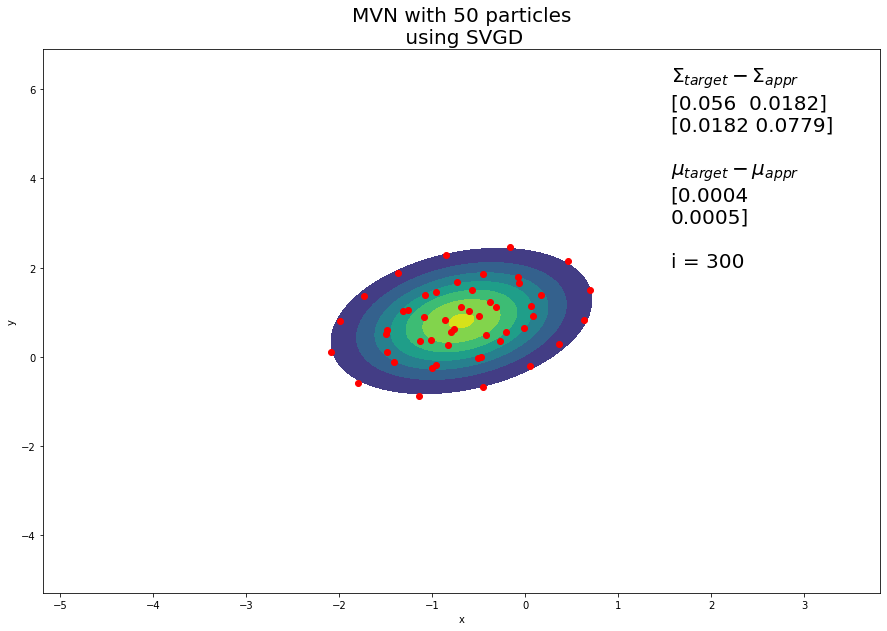

In [6]:
plot2d(model, theta, iteration = n_iter, subtitle='using SVGD')

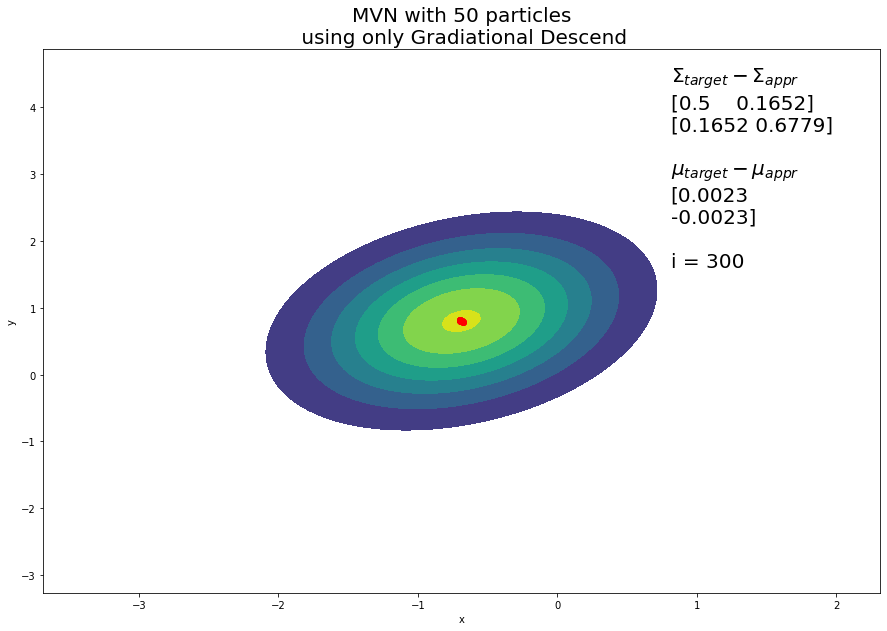

In [7]:
theta_grad = SVGD().only_gradient(theta, model.dlnprob, n_iter=n_iter, stepsize=0.01)
plot2d(model, theta_grad, iteration = n_iter, subtitle='using only Gradiational Descend', limitscale=6)

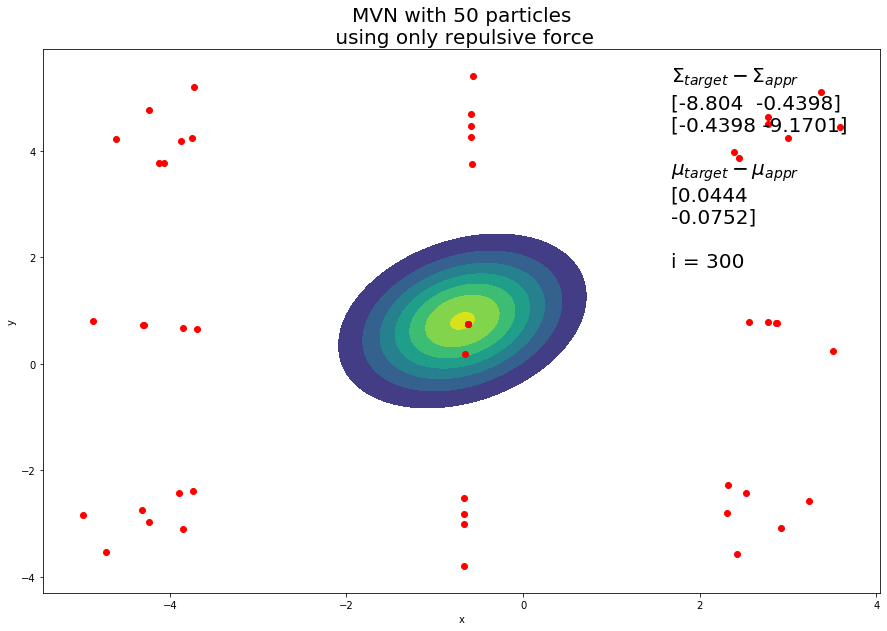

In [8]:
theta_grad = SVGD().only_kernel(theta, model.dlnprob, n_iter=n_iter, stepsize=0.01)
plot2d(model, theta_grad, iteration = n_iter, subtitle='using only repulsive force', limitscale=6)

In [9]:
%matplotlib inline
import matplotlib.animation as animation

# animate the svgd
# build list of theta iterations
x0 = np.random.normal(0,1, [50,2])
thetas = []
for i in range(500):
    x1 = SVGD().update(x0, model.dlnprob, n_iter=i, stepsize=0.01)
    thetas.append(x1)

def animate_svgd(i, ax):
    ax.clear()
    plot2d(model, thetas[i], ax, i, subtitle='using SVGD')

In [34]:
# animate the gradiational part
# build list of theta iterations
x0 = np.random.normal(0,1, [50,2])
n_iter = 300
theta = SVGD().update(x0, model.dlnprob, n_iter=n_iter, stepsize=0.01)
thetas_grad = []
for i in range(200):
    x1 = SVGD().only_gradient(theta, model.dlnprob, n_iter=i, stepsize=0.01)
    thetas_grad.append(x1)

def animate_grad(i, ax):
    ax.clear()
    plot2d(model, thetas_grad[i], ax, i, subtitle='only gradient descend', limitscale=6)

In [50]:
# animate the kernel part
# build list of theta iterations
x0 = np.random.normal(0,1, [50,2])
n_iter = 300
theta = SVGD().update(x0, model.dlnprob, n_iter=n_iter, stepsize=0.01)
thetas_kernel = []
for i in range(200):
    x1 = SVGD().only_kernel(theta, model.dlnprob, n_iter=i, stepsize=0.01)
    thetas_kernel.append(x1)

def animate_kernel(i, ax):
    ax.clear()
    plot2d(model, thetas_kernel[i], ax, i, subtitle='only repulsive force', limitscale=6)

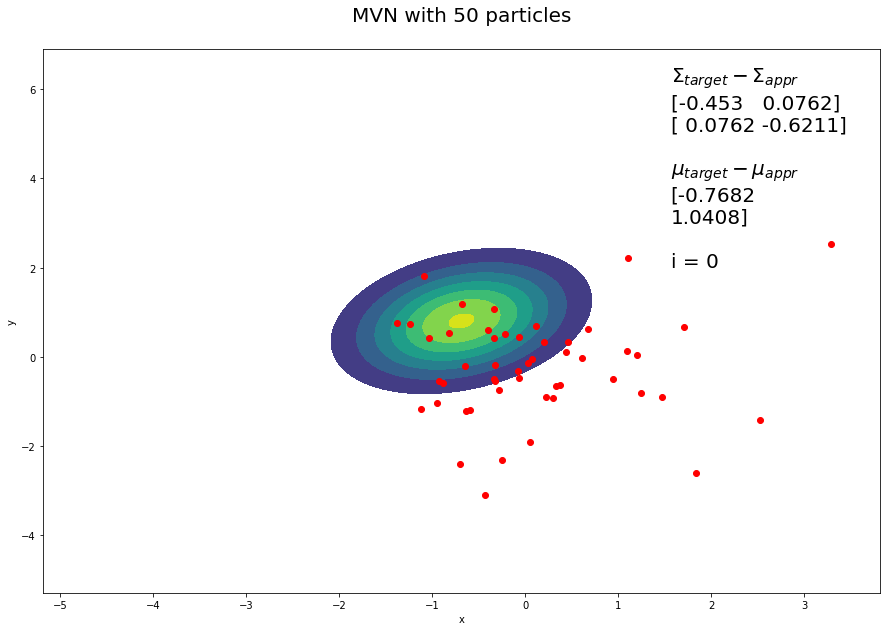

In [20]:
# create svgd animation
fig, ax = plt.subplots(1,figsize=(15,10))
ani = animation.FuncAnimation(fig, lambda i: animate_svgd(i, ax=ax), frames=10, repeat=True)

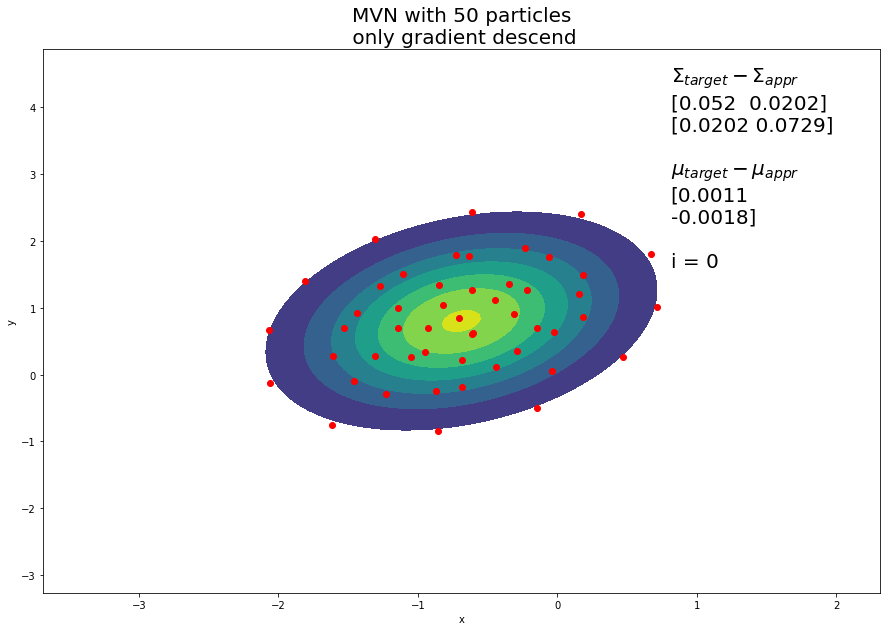

In [36]:
# create grad animation
fig, ax = plt.subplots(1,figsize=(15,10))
ani_grad = animation.FuncAnimation(fig, lambda i: animate_grad(i, ax=ax), frames=200, repeat=True)

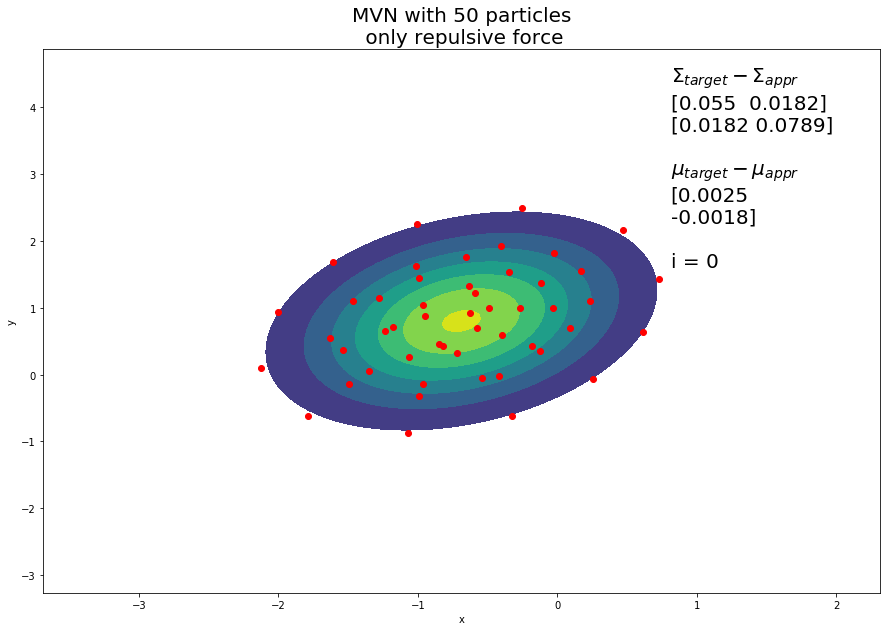

In [51]:
# create kernel animation
fig, ax = plt.subplots(1,figsize=(15,10))
ani_kernel = animation.FuncAnimation(fig, lambda i: animate_kernel(i, ax=ax), frames=200, repeat=True)

In [52]:
# save animations
Writer = animation.writers['imagemagick']
writer = Writer(fps=20, bitrate=900)

In [ ]:
ani.save('.//svgd_mvn.gif', writer=writer)

In [ ]:
ani_grad.save('.//grad_mvn.gif', writer=writer)

In [53]:
ani_kernel.save('.//kernel_mvn.gif', writer=writer)